In [ ]:
! pip install qiskit qiskit-ibm-runtime rustworkx scipy typing

# Import statements

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
#from qiskit_ibm_runtime.fake_provider import FakeKyiv
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator, QiskitRuntimeService
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
from qiskit_ibm_runtime import SamplerV2 as Sampler
#from qiskit_aer import AerSimulator
#from qiskit_aer.noise import NoiseModel
from typing import Sequence

# Loading the Zachary Karate Club Dataset

In [2]:
zachary_graph = []
with open("zachary_soc.txt","r") as f1:
    for s in f1:
        s = s.strip().split()
        zachary_graph.append((int(s[0]),int(s[1]),1.0))

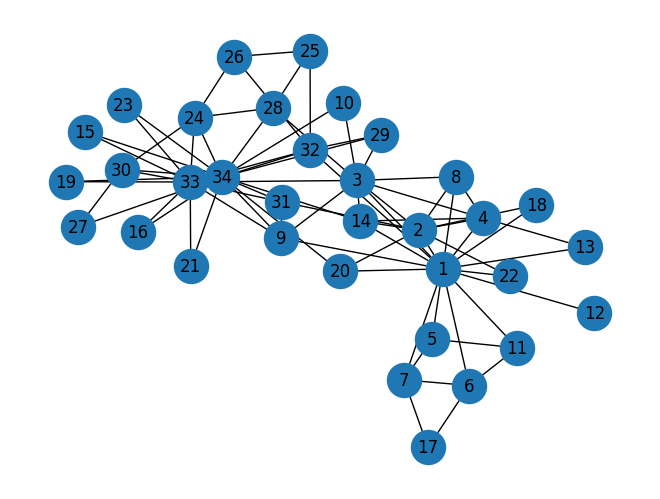

In [3]:
n = 34
zac_graph = rx.PyGraph(); 
zac_graph.add_nodes_from(np.arange(0, n+1, 1));zac_graph.remove_node(0)
zac_graph.add_edges_from(zachary_graph)
draw_graph(zac_graph, node_size=600, with_labels=True)

# Loading Graph with 60 nodes and 885 edges
> max-cut of graph is 536

> [Link to graph](https://biqmac.aau.at/library/mac/rudy/g05_100.0)

> [Optimum cut value, page-9,entry g05 100.0](https://biqmac.aau.at/biqmaclib.pdf)

In [5]:
mac60_graph = []
with open("mac60.txt","r") as f1:
    for s in f1:
        s = s.strip().split()
        mac60_graph.append((int(s[0]),int(s[1]),1.0))

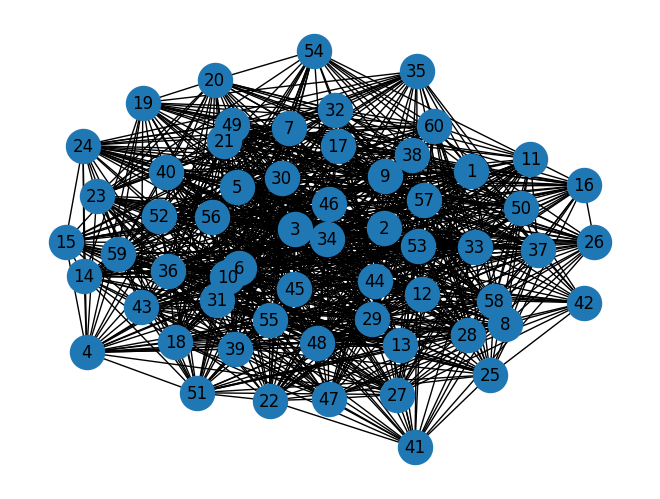

In [6]:
n = 60
graph60 = rx.PyGraph(); 
graph60.add_nodes_from(np.arange(0, n+1, 1));graph60.remove_node(0)
graph60.add_edges_from(mac60_graph)
draw_graph(graph60, node_size=600, with_labels=True)

# Loading graph of 100 nodes and 2475 edges
> Max-cut value is 1430

> [Link to graph](https://biqmac.aau.at/library/mac/rudy/g05_100.0)

> [Optimum cut value, page 9, entry g05 60.0](https://biqmac.aau.at/biqmaclib.pdf)

In [7]:
mac100_graph = []
with open("mac100.txt","r") as f1:
    for s in f1:
        s = s.strip().split()
        mac100_graph.append((int(s[0]),int(s[1]),1.0))

In [8]:
n = 100
graph100 = rx.PyGraph(); 
graph100.add_nodes_from(np.arange(0, n+1, 1));graph100.remove_node(0)
graph100.add_edges_from(mac100_graph)
draw_graph(graph100, node_size=600, with_labels=True)

# Bruteforce solution to Zachary's graph's Max-cut

In [9]:
import itertools

def max_cut_bruteforce(G):
    """
    Brute-force search for the maximum cut of a graph.
    
    Parameters:
        G (networkx.Graph): The input graph.

    Returns:
        best_cut (tuple): The optimal partition (S, T) that maximizes the cut.
        max_cut_size (int): The size of the maximum cut.
    """
    nodes = list(G.node_indexes())
    n = len(nodes)
    edges = list(G.edge_list())
    
    max_cut_size = 0
    best_cut = None

    # Iterate over all possible subsets S (2^n possibilities)
    for bits in itertools.product([0, 1], repeat=n):
        # Compute cut size: count edges between S and T
        cut_size = 0
        for u,v in  edges:
            cut_size += bits[u-1]+bits[v-1]-2*bits[u-1]*bits[v-1]
        
        if cut_size > max_cut_size:
            max_cut_size = cut_size
            best_cut = bits
    
    return best_cut, max_cut_size

In [ ]:
%%time
max_cut_bruteforce(zac_graph)

# Preparing Cost Hamiltonian

In [9]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]-1], paulis[edge[1]-1] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis1 = build_max_cut_paulis(zac_graph)
max_cut_paulis2 = build_max_cut_paulis(graph60)
max_cut_paulis3 = build_max_cut_paulis(graph100)

cost_hamiltonian1 = SparsePauliOp.from_list(max_cut_paulis1)
cost_hamiltonian2 = SparsePauliOp.from_list(max_cut_paulis2)
cost_hamiltonian3 = SparsePauliOp.from_list(max_cut_paulis3)
print("Cost Function Hamiltonian1:", cost_hamiltonian1)
print("Cost Function Hamiltonian2:", cost_hamiltonian2)
print("Cost Function Hamiltonian3:", cost_hamiltonian3)

Cost Function Hamiltonian1: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIZI', 'IIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIII

# Preparing Parametried circuit(Ansatz)
Note: the Initial state is equisuperposition state

In [10]:
iterations = 2

In [11]:
circuit1 = QAOAAnsatz(cost_operator=cost_hamiltonian1, reps=iterations)
circuit1.measure_all()
circuit2 = QAOAAnsatz(cost_operator=cost_hamiltonian2, reps=iterations)
circuit2.measure_all()
circuit3 = QAOAAnsatz(cost_operator=cost_hamiltonian3, reps=iterations)
circuit3.measure_all()

#circuit.decompose().draw('mpl')

# Transpiling circuit for Fake Backend

In [ ]:
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="<api_token>", overwrite=True, set_as_default=True)
service1 = QiskitRuntimeService(channel='ibm_quantum')
backend1 = service1.least_busy(min_num_qubits=127,simulator=False, operational=True)
print(backend1)

<IBMBackend('ibm_kyiv')>


In [ ]:
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="<api_token>", overwrite=True, set_as_default=True)
service2 = QiskitRuntimeService(channel='ibm_quantum')
backend2 = service2.least_busy(min_num_qubits=127,simulator=False, operational=True)
print(backend2)

<IBMBackend('ibm_kyiv')>


In [ ]:
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="<api_token>", overwrite=True, set_as_default=True)
service3 = QiskitRuntimeService(channel='ibm_quantum')
backend3 = service3.least_busy(min_num_qubits=127,simulator=False, operational=True)
print(backend3)

<IBMBackend('ibm_kyiv')>


In [ ]:
## using simulator
# real_backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(real_backend)
# sim_backend = AerSimulator()  #.from_backend(real_backend)
# sim_backend.set_options(method="matrix_product_state")
# # Create pass manager for transpilation
# pm = generate_preset_pass_manager(optimization_level=1,
#                                   #basis_gates=sim_backend.configuration().basis_gates,
#                                   backend=sim_backend)

# candidate_circuit = pm.run(circuit)
# #candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [18]:
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend1)

candidate_circuit1 = pm.run(circuit1)

In [19]:
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend2)

candidate_circuit2 = pm.run(circuit2)

In [ ]:
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend3)

candidate_circuit3 = pm.run(circuit3)

# QAOA iterations
Note: Estimator primitive is used to estimate the expected Cost function in optimization loop and Sampler primitive is used to get minimum cost eigenvector probability distribution

## Defining initial parameters

In [19]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta]*iterations

## Optimization Loop

In [20]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator,objective_func_vals):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [21]:
%%time
objective_func_vals1 = [] # Global variable
with Session(backend=backend1) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result1 = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit1, cost_hamiltonian1, estimator, objective_func_vals1),
        method="COBYLA",
        tol=1e-2,
    )
    print(result1)

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

Note: 
job1: 
>       Created: Mar 18, 2025 3:25 AM
>       Pending: 2m 50.5s
>       In progress: Mar 18, 2025 3:28 AM
>        Qiskit runtime usage: 12s
>       Completed: Mar 18, 2025 3:36 AM
job2:
>       Created: Mar 18, 2025 3:36 AM
>       Pending: 3.1s
>       In progress: Mar 18, 2025 3:36 AM
>       Qiskit runtime usage: 11s
>       Completed: Mar 18, 2025 3:38 AM
job3:
>       Created: Mar 18, 2025 3:39 AM
>       Pending
>       In progress
>       Estimated usage: 7.3s
>       Completed

It seems session can't be used for ibm free plan, since each job in session is queued separately for free plan users, which means session max TTL will definitely reach. So, free plan users better not use session mode.

In [ ]:
%%time
objective_func_vals2 = [] # Global variable
with Session(backend=backend2) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result2 = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit2, cost_hamiltonian2, estimator, objective_func_vals2),
        method="COBYLA",
        tol=1e-2,
    )
    print(result2)

In [ ]:
%%time
objective_func_vals3 = [] # Global variable
with Session(backend=backend3) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result3 = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit3, cost_hamiltonian3, estimator, objective_func_vals3),
        method="COBYLA",
        tol=1e-2,
    )
    print(result3)

## Plotting Energy vs Iterations

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("34 nodes graph")
plt.plot(objective_func_vals1)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("60 nodes graph")
plt.plot(objective_func_vals2)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("100 nodes graph")
plt.plot(objective_func_vals3)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

## Sampling Max-cut solutions from optimized circuit

In [ ]:
optimized_circuit1 = candidate_circuit1.assign_parameters(result1.x)

In [ ]:
optimized_circuit2 = candidate_circuit2.assign_parameters(result2.x)

In [ ]:
optimized_circuit3 = candidate_circuit3.assign_parameters(result3.x)

In [ ]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler1 = Sampler(mode=backend1)
sampler1.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler1.options.dynamical_decoupling.enable = True
sampler1.options.dynamical_decoupling.sequence_type = "XY4"
sampler1.options.twirling.enable_gates = True
sampler1.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit1, )
job = sampler1.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int1 = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin1 = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int1)

In [ ]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler2 = Sampler(mode=backend2)
sampler2.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler2.options.dynamical_decoupling.enable = True
sampler2.options.dynamical_decoupling.sequence_type = "XY4"
sampler2.options.twirling.enable_gates = True
sampler2.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit2, )
job = sampler2.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int2 = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin2 = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int2)

In [ ]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler3 = Sampler(mode=backend3)
sampler3.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler3.options.dynamical_decoupling.enable = True
sampler3.options.dynamical_decoupling.sequence_type = "XY4"
sampler3.options.twirling.enable_gates = True
sampler3.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit3, )
job = sampler3.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int3 = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin3 = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int3)

# Returning result in classical format

In [ ]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int1.keys())
values = list(final_distribution_int1.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring1 = to_bitstring(most_likely, len(zac_graph))
most_likely_bitstring1.reverse()

print("Result bitstring:", most_likely_bitstring1)

In [ ]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin1
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution graph 34")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

In [ ]:
# visualizing cut
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(zac_graph, most_likely_bitstring1)

In [ ]:
# auxiliary functions to sample most likely bitstring
keys = list(final_distribution_int2.keys())
values = list(final_distribution_int2.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring2 = to_bitstring(most_likely, len(graph60))
most_likely_bitstring2.reverse()

print("Result bitstring:", most_likely_bitstring2)

In [ ]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin2
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution graph 60")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

In [ ]:
# auxiliary functions to sample most likely bitstring
keys = list(final_distribution_int3.keys())
values = list(final_distribution_int3.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring3 = to_bitstring(most_likely, len(graph100))
most_likely_bitstring3.reverse()

print("Result bitstring:", most_likely_bitstring3)

In [ ]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin3
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution graph 100")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

# Calculating value of Cut

In [ ]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))

cut_value1= evaluate_sample(most_likely_bitstring1, zac_graph)
print('The value of the cut the zachary graph is:', cut_value1)

In [ ]:
cut_value2= evaluate_sample(most_likely_bitstring2, graph60)
print('The value of the cut of the graph with 60 nodes is:', cut_value2)

In [ ]:
cut_value3= evaluate_sample(most_likely_bitstring3, graph100)
print('The value of the cut of the graph with 100 nodes is:', cut_value3)

# Summarising results
| Algorithm | Time(34 nodes) | Time(60 nodes) | Time(100 nodes) | Success Rate |
| :-------: | :------------: | :------------: | :-------------: | :----------: |
| Clasical  |   TBD          |      TBD       |     TBD         |   100%       |
|   QAOA    |   TBD          |      TBD       |     TBD         |   TBD        |
|   Optimal |   TBD          |      TBD       |     TBD         |   TBD        |